In [1]:
from qiskit import *
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram

import numpy as np

The idea here is to use Grover's Search Algorithm to search our input list for a number. 

Our input list may consist of positive and negative integers, and our goal is to determine with the aid of a quantum program whether or not there is a negative number in the list.

To use Grover's algorithm, we have to define a winning element 'w'. However, there are an infinite amount of negative numbers, so we shall do a bit of preprocessing beforehand.
By dividing each member of the input list by the absolute value of itself, we obtain a list of positive and negative one's.

Hence, we reduce our number of candidate winning elements to just one.We then define our winning element as -1, so we can perform Grover's Algorithm.

After running, we get a distribution of probablities (example below). 
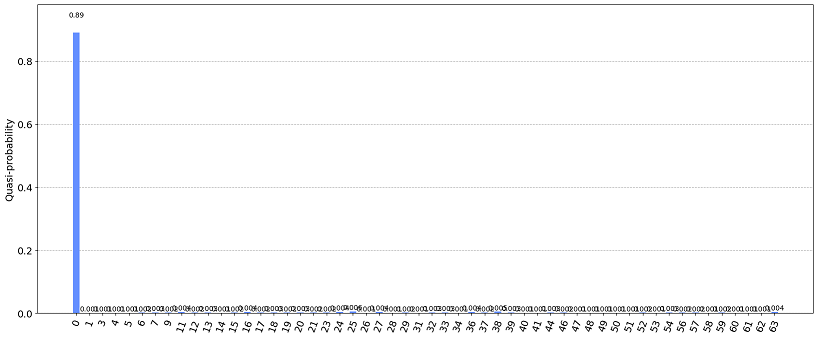

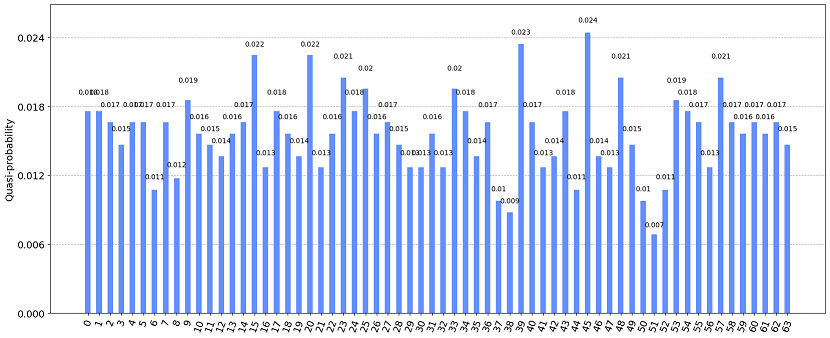

From the first graph below, we can see that Grover's Algorithm finds a negative number with very high probability.

From the second graph, the probabilities of all outcomes are '_relatively_' equal, indicating that Grover's Algorithm has not found a negative number.

Since we are required to return a __True__ or __False__ rather than an image, we do a bit of postprocessing on the probability values. 
If we take these probabilities into a list, and analyse the probabilities, we can determine if there was a negative number.

The method used is based on the assumption that the maximum probability will always be much larger than the minimum of the probabilities.

Hence if    max(<span style='color:Blue'> list_of_probabilities</span>) - min(<span style='color:Blue'> list_of_probabilities</span>) - 10* min(<span style='color:Blue'> list_of_probabilities</span>) is a positive number, then there is very likely a negative number in the input list.

If however, max(<span style='color:Blue'> list_of_probabilities</span>) - min(<span style='color:Blue'> list_of_probabilities</span>) - 10* min(<span style='color:Blue'> list_of_probabilities</span>) is a negative number, then there is very likely no negative number in the input list.

# Preprocessing

In [2]:
def preprocessing(inp):
    
    """
    Takes in an input list of positive and negative integers: inp
    Returns a processed modified list with 1's and -1's
    """
    
    # Since Grover's search works better for larger structures, we check if the length of our input
    # is less than 150, if it is, we calculate a multiplicative constant to multiply the list 
    # to make it to be close to 200.
    
    len_input = len(inp)
    factor = 1

    if len_input < 150:
        factor = int(np.ceil(200/len_input))

    lis = inp * factor # e.g [2, 3] * 3 = [2, 3, 2, 3, 2, 3]
    
    
    # Next, to apply Grover's algorithm, we divide each item in the list by 
    # the absolute value of itself, so we only have 1's and -1's
    # The goal of Grover's algorithm is then to find a -1 in the list
    
    res = []
    
    for i in range(len(lis)):
        
        if lis[i] == 0:
            res.append(lis[i])
        else:
            res.append(lis[i]/np.abs(lis[i]))
    
    return res

# Grover's Algorithm

## Defining the oracle's

We define the Reflector and Diffuser oracles for Grover's algorithm.

The Reflector oracle U<sub>f</sub> is defined as:

$$ U_{f} = I  -  2 * |w><w|; $$
where w is the winning state 


The Diffuser oracle U<sub>fo</sub> is defined as:

$$ U_{fo} = 2*|0><0|^{\otimes n} - I $$

In [3]:
def oracle(res):
    
    """
    Defines the Reflector and Diffuser oracles
    """
    
    global n 
    n = int(np.ceil(np.log2(len(res)))) ## Getting the least number of qubits required to represent the number of items in res
    
    
    w = [-1] ## The winning element is -1
    
    ####################################################################################
    ## Creatiing the Reflector
    
    id_1 = np.eye(2**int(n))
    
    ind = []
    for i in w:
        if i in res:
            ind.append(res.index(i))
            
    
    for j in range(len(id_1)):
    
        if j in ind:
            id_1[:,j] = -1*id_1[:,j]
    ####################################################################################
    ## Creating the Diffuser
    
    id_2 = np.eye(2**int(n))
    
    one = np.ones(2**n) *(1/(2**n))
    
    diff = 2*one - id_2
    
    ####################################################################################
        
    ref = UnitaryGate(id_1, label= 'Reflector')
    dif = UnitaryGate(diff, label= 'Diffuser')
    
    return ref, dif

## Quantum Circuit

The optimal number of times to apply the oracles is calculated as:

$$ r = \frac{\pi}{4} \sqrt{N} $$

In [4]:
def grover(ref, dif):
    
    """
    Applies the Grover Circuit, measures,
    Returns list of probabilities, and the quantum circuit used
    """
    
    ####################################################################################
    r = int(np.ceil((np.pi/4) * np.sqrt(2**n)))
    # Calculating the optimum number of times to apply the Reflector and Diffuser
    
    ####################################################################################
    qc = QuantumCircuit(n)

    qc.h(list(range(n)))

    for i in range(r):
        qc.append(ref, list(range(n)))
        qc.append(dif, list(range(n)))

    qc.measure_all()

    global draw 
    circuit = qc.draw('mpl')
    
    ####################################################################################
    
    from qiskit_aer.primitives import Sampler as AerSampler

    sim = AerSampler()

    result = sim.run(qc).result()
    
    ####################################################################################
    
    prob = list(result.quasi_dists[0].values())
    
    graph = plot_histogram(result.quasi_dists[0], figsize= (20,8))
    # We get the list of probabilities which we examine to determine the answer.
    
    return prob, circuit, graph

# Post Processing

In [5]:
def postprocessing(prob):
    
    """
    Uses list of probabilities to determine if there is a negative number
    Returned value will be positive if there is a negative value
    """

    prob = np.array(prob)
    
    answer = max(prob) - min(prob) - 10*min(prob)
    
    return answer

# Finalizing

In [6]:
def find_negative(lis):
    
    global circuit, prob, graph

    res = preprocessing(lis)
    
    ref, dif = oracle(res)
    
    prob, circuit, graph = grover(ref, dif)
    
    value = postprocessing(prob)
    
    if value > 0:
        return True
    else:
        return False

In [7]:
lis = list(np.random.randint(-50, 70, 350))

In [8]:
find_negative(lis)

True

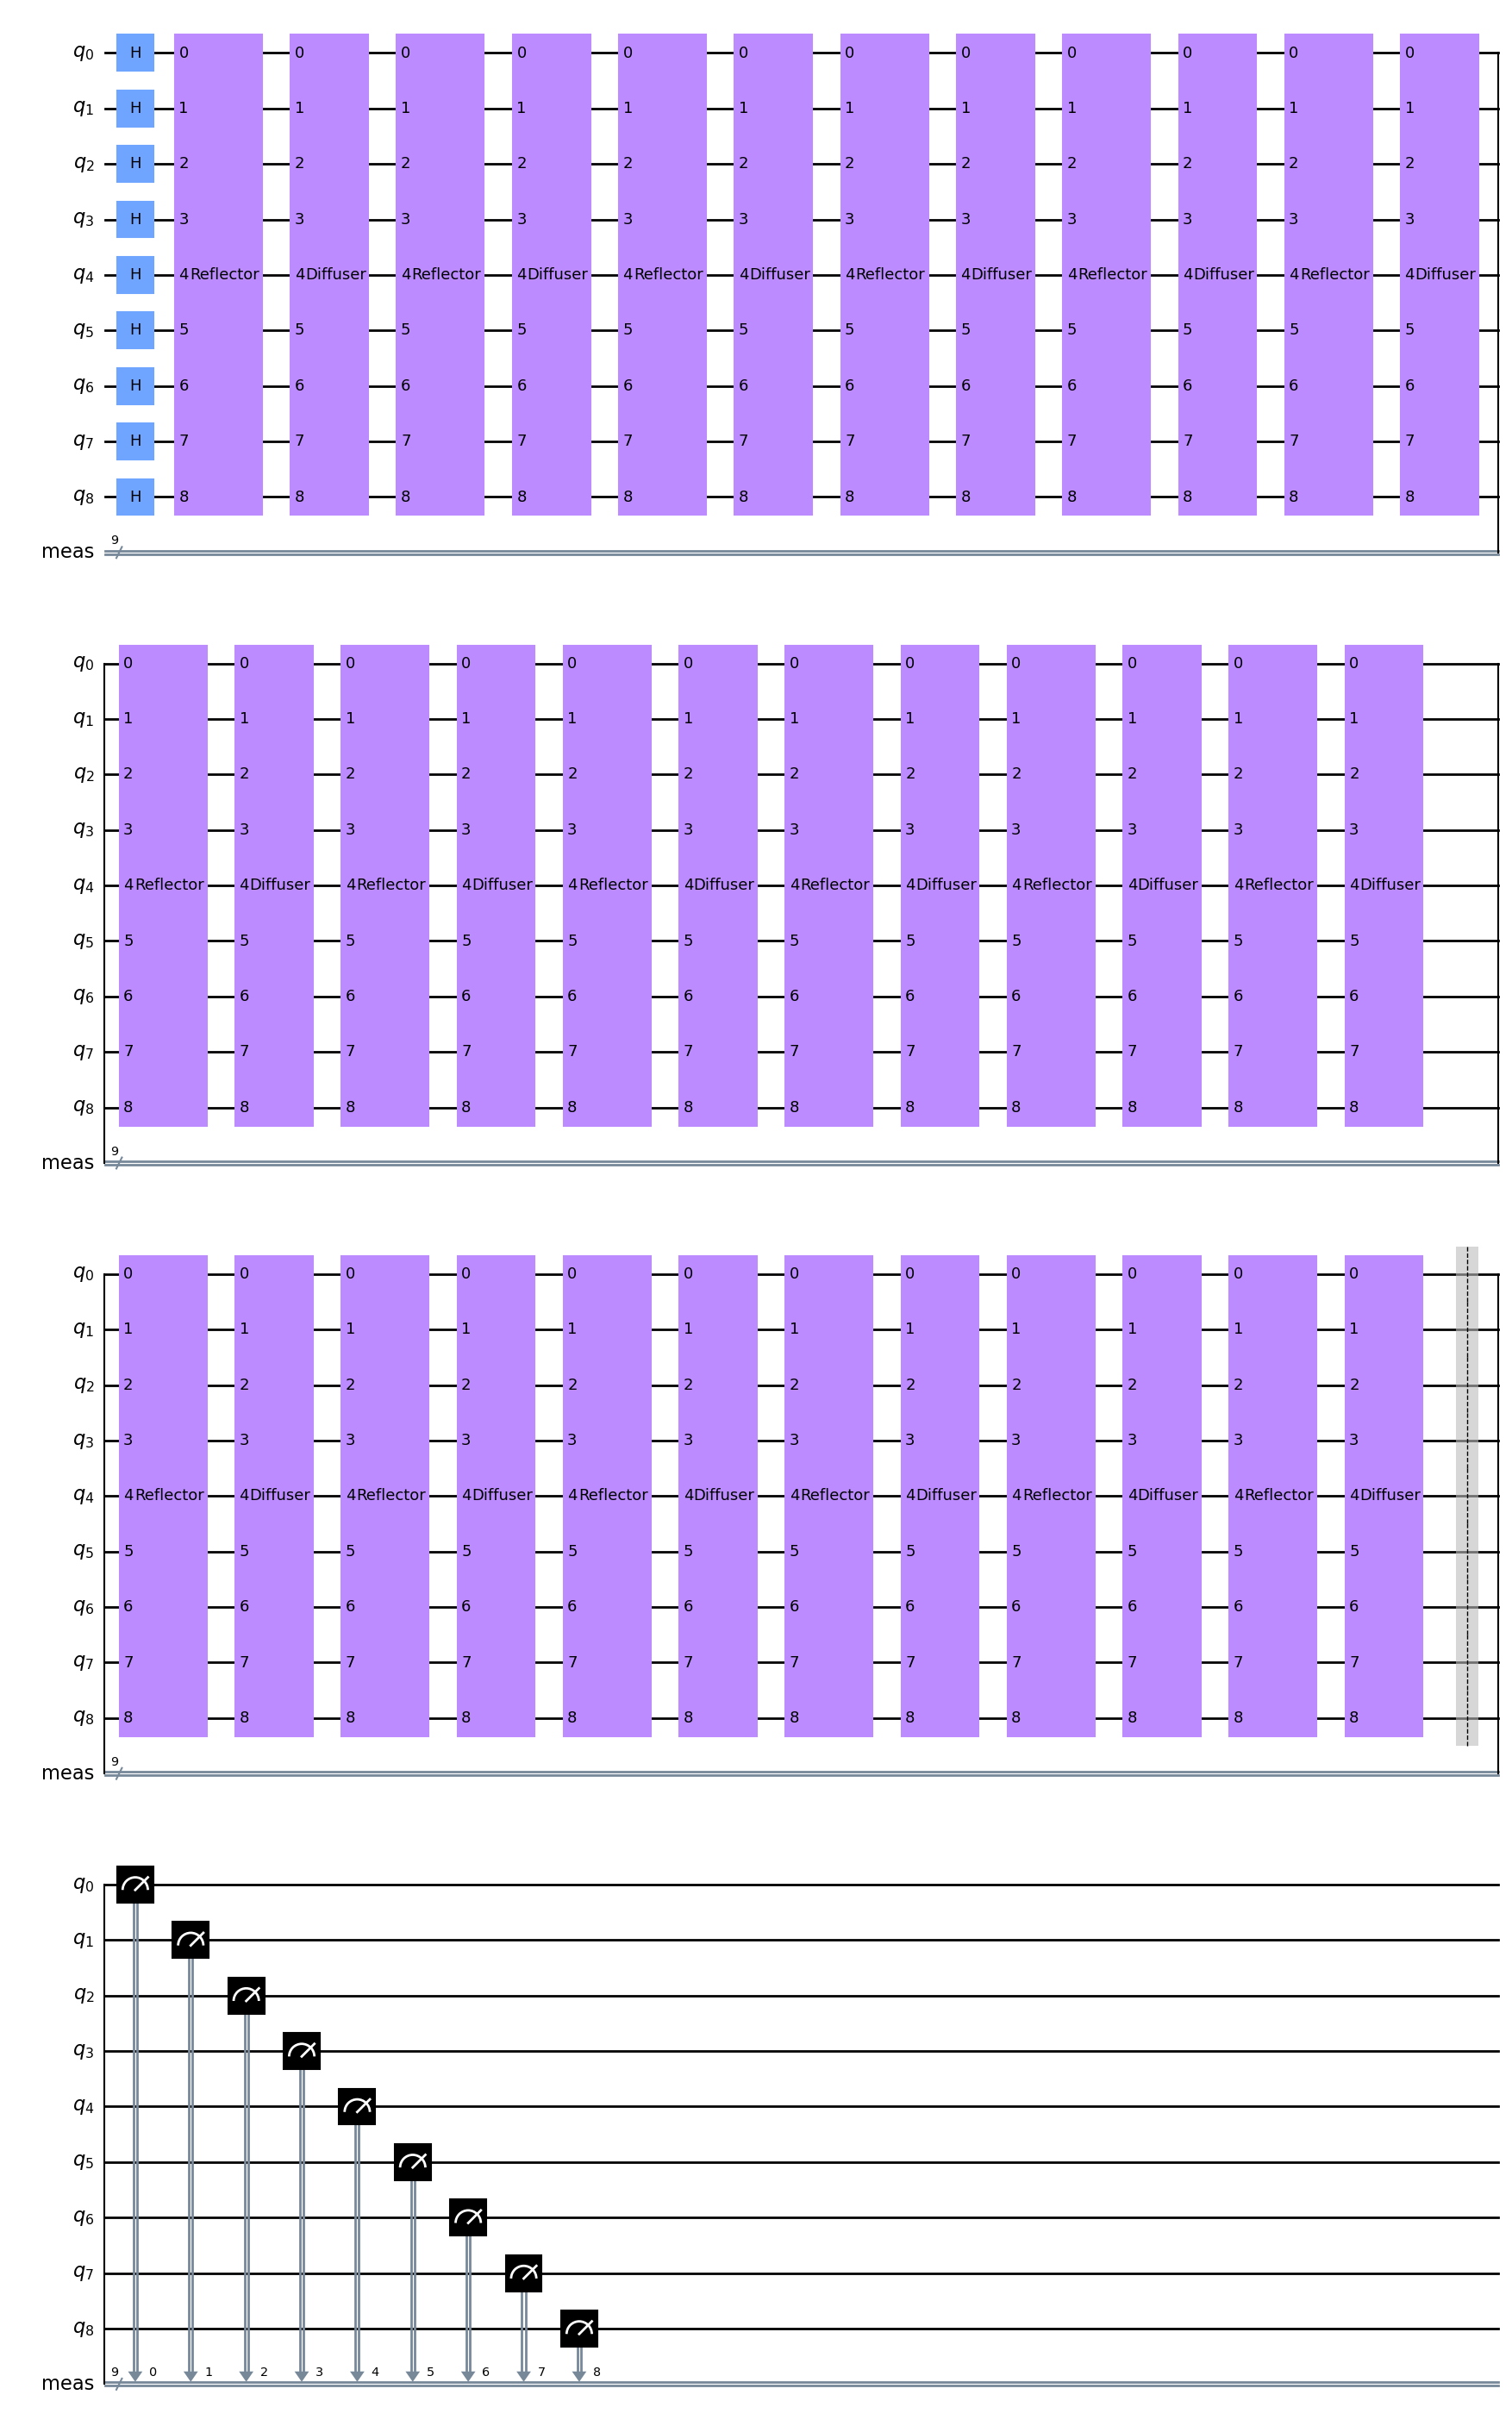

In [9]:
## Uncomment to view the circuit used.

# circuit

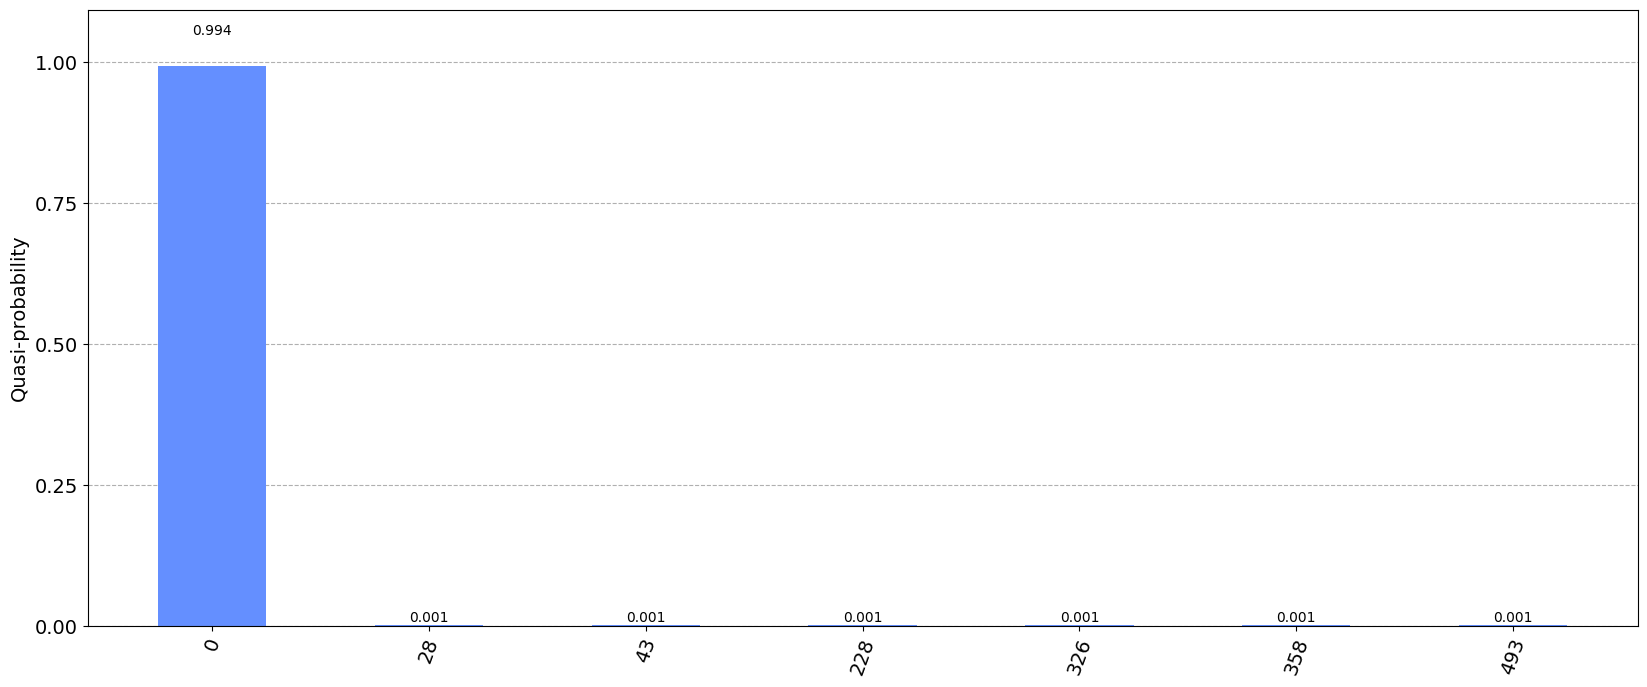

In [10]:
## Uncomment to view the plot of probabilities.

graph

Comparing the runtime of my quantum solution to a simple classical algorithm reveals that the classical algorithm outclasses my quantum solution

In [11]:
%%time

find_negative(lis)

CPU times: user 1.48 s, sys: 703 ms, total: 2.19 s
Wall time: 1.24 s


True

In [12]:
%%time

for i in lis:
    
    if i<0:
        print('Found')
        break

Found
CPU times: user 24 µs, sys: 14 µs, total: 38 µs
Wall time: 42.4 µs


Additionally, we can run the cell below to view the accuracy of my solution on a hundred randomly generated lists.

In [13]:
pred = 0
truth = 0

for i in range(100):
    
    lis = list(np.random.randint(-1, 60, 95))
    for i in lis:
        if i < 0:
            truth += 1
            break
    
    res = find_negative(lis)
    if res == True:
        pred += 1
        
print(f"The number of times a negative number appeared is {truth}")
print(f"The number of times we found a negative number is {pred}")

The number of times a negative number appeared is 78
The number of times we found a negative number is 78


Looking at the results obtained above, I can deduce that my quantum solution is reasonably accurate.